In [ ]:
!pip install ipython-sql
!pip install psycopg2-binary
#!pip install matplotlib
#!pip install pandas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import psycopg2 as pg
cn = pg.connect("host='pg' dbname='ethernauta' user=postgres password=")
import queries.sqls as q

In [7]:
%reload_ext sql
%sql postgresql://postgres@pg/ethernauta

'Connected: postgres@ethernauta'

# Procesamiento de los datos

Se recupera de la cadena de bloques, un historial de transacciones que viene en el siguiente formato

|**columna**|**descripcion**|
|-----------|---------------|
|ts| Tiempo en formato Unix|
|hash| ID unico de la transaccion|
|from_address| Cuenta origen |
|to_address| Cuenta destino |
|ethers| Cantidad de Wei (Ether/10^E+18) transferidos|

Mediante un proceso ETL, cargamos esta informacion a la tabla "ctacte" con las siguiente modificaciones

* Se descartaron aquellos registros que:
 * valor = 0
 * estado != 1
 * correspondiente a contratos digitales
* Se cambio Wei a Ethers multiplicando por 10^E+18
* Se agrego la columna *price*, obtenida por otra fuente ajustada a los 5 minutos previos mas recientes.
* Por cada registro de transaccion se agregaron 2 registros a la cuenta corriente
 * Uno por la venta de *from_address*
 * Otro por la compra de *to_address*

La tabla **ctacte** quedo asi:

In [29]:
%sql select * from ctacte limit 3

 * postgresql://postgres@pg/ethernauta
3 rows affected.


[('0xab2f50d10b05323fb4e62abac79704a73b9628ac6bb243574acc765b47981556', 1582005287, '0x0c79c70b737c8ab46826ab934cdd44b76a999b37', Decimal('1.00000000000000000000'), Decimal('259.2200'), Decimal('-259.2200'), 287),
 ('0x94fd0d01784db19607f6549616a5759b52aec0181c19335e3ed1751d1ac5dac8', 1582005287, '0xf38031d1cbe09cc4c4dfc342bb61513aa3a61667', Decimal('0.00200000000000000000'), Decimal('259.2200'), Decimal('-0.5184'), 287),
 ('0x032948212bdd9098f73312658084266a63e0678cd6393058e3278f1996ad1abe', 1582005287, '0x1a8457fad745c59ebd78889f98a2002a9fe0e790', Decimal('2.00000000000000000000'), Decimal('259.2200'), Decimal('-518.4400'), 287)]

# Seleccion de las mejores cuentas

Para realizar la seleccion de las mejores cuentas, se utlizo el sig. metodo

TODO

En la tablas **scoring_m3** se registraron las cuentas con el scoring

In [10]:
%sql select address, round(diff) from scoring_m3_pg order by diff desc limit 5

 * postgresql://postgres@pg/ethernauta
5 rows affected.


[('0x4a7d1a847255189b25f3fd89a2ef4b51456fa507', 875612.0),
 ('0x66af9103aed76c0bf9045bf182516868f9f95b8f', 258992.0),
 ('0xc2fc299fe5cd155cb0e8df554ce067c771979bff', 222845.0),
 ('0x6175139a99ffecf945cbaeae88c898a43501b727', 185068.0),
 ('0xf1bd8e36a0e48650bdb28056277b05e851ebbae8', 184258.0)]

Ahora visualizamos las operaciones de las cuentas mas exitosas

In [12]:
#dataframe = psql.DataFrame("SELECT * FROM category", connection)
df = pd.read_sql_query('select * from ctacte_m3 order by diff desc limit 5',con=cn)
df

hash          ts  \
0  0x67ec1f81920abd76179361e9cdeedeb152cf81faa8c7...  1582106973   
1  0x7630c5cf9a1f4e9949fb4200bbd368df76fb29f96138...  1582047427   
2  0x0419ac7dc36ae2e7b01527497f30dd62c793e92b422c...  1581781959   
3  0x628403b7e372ad56c20dffc0e066038d96a078a6cae9...  1582097177   
4  0xc36db9b24184dc86508213e8aa1c830ab72730b82712...  1582354845   

                                      address         ethers   price  \
0  0x742d35cc6634c0532925a3b844bc454e4438f44e  -50000.000000  282.37   
1  0x4a7d1a847255189b25f3fd89a2ef4b51456fa507  -54352.087202  269.29   
2  0x3f5ce5fbfe3e9af3971dd833d26ba9b5c936f0be -129436.158571  281.64   
3  0x88d34944cf554e9cccf4a24292d891f620e9c94f  -25000.000000  278.41   
4  0x1c11ba15939e1c16ec7ca1678df6160ea2063bc5 -125000.000000  266.24   

           cost  ts_diff                                    last_add  \
0  1.411850e+07      273  0x742d35cc6634c0532925a3b844bc454e4438f44e   
1  1.463647e+07      127  0x4a7d1a847255189b25f3fd89a2ef4b51456fa507   
2  3.645440e+07      159  0x3f5ce5fbfe3e9af3971dd833d26ba9b5c936f0be   
3  6.960250e+06       77  0x88d34944cf554e9cccf4a24292d891f620e9c94f   
4  3.328000e+07       45  0x1c11ba15939e1c16ec7ca1678df6160ea2063bc5   

   balance_e  buy_avg     last_ts     op  minutes_from_last_tx  e_out  e_in  \
0  125868.32   264.02  1582106973  VENDE                  2.48    1.0   0.0   
1       0.00   253.18  1582047427  VENDE                  0.00    1.0   0.0   
2       0.00   276.77  1581781959  VENDE                  0.00    1.0   0.0   
3       0.00   259.59  1582097177  VENDE                  0.00    1.0   0.0   
4    7853.48   263.48  1582354845  VENDE                  0.63    1.0   0.0   

   uss_out       uss_in       diff  diff_per   diff_e  
0      0.0  14118500.00  917385.09      0.06  3248.88  
1      0.0  14636473.56  875612.12      0.06  3251.56  
2      0.0  26373510.53  456463.90      0.02  1620.74  
3      0.0   6502599.55  439524.66      0.07  1578.70  
4      0.0  33280000.00  345332.67      0.01  1297.07

# Histograma de las cuentas mas exitosas



%matplotlib inline
plt.figure(figsize=(15,3))
plt.hist(df['diff'], 10)
plt.title('Histograma de las diferencias logradas por las 100 mejores cuentas')
plt.show()

In [2]:
df_txs_top100 = pd.read_sql_query(q.txs_top100, cn)
df_txs_bottom100 = pd.read_sql_query(q.txs_bottom100, cn)
df_prices = pd.read_sql_query(q.prices, cn)


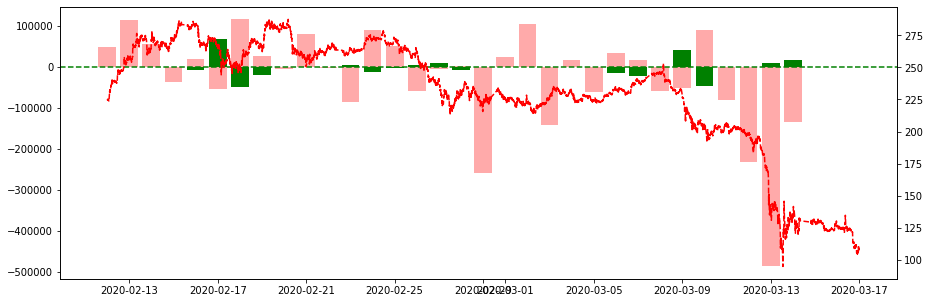

In [16]:
a = 'ethers'
fig = plt.figure(figsize=(15, 5))
ax1 = plt.subplot(111)
ax1.bar(df_txs_top100['fecha'], df_txs_top100[a], color='g')
ax1.bar(df_txs_bottom100['fecha'], df_txs_bottom100[a], color='#ffaaaa')
plt.axhline(y=0, color='g', linestyle='--')
ax2 = ax1.twinx()
ax2.plot(df_prices['fecha'], df_prices['price'], 'r--')
#plt.subplot(212)
#plt.bar(df['address'], df['ethers'])
plt.show()
